## Importing libraries

In [3]:
import tensorflow as tf
import csv
import re
import os
import emoji
import copy
import matplotlib.pyplot as plt
from tabulate import tabulate
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Input
from keras.models import Model

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ferdo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Analyzing the dataset

The dataset is made of 2 files:
- raw_test_data.tsv
- raw_training_data.tsv

Let's start analyzing the training one:

## Training set

In [4]:
def read_set(input_set):
    data = []
    with open(input_set, 'r', encoding='utf-8') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter='\t')
        next(tsv_reader)

        for row in tsv_reader:
            sample = {}
            sample['text'] = row[1]
            sample['misogynous'] = int(row[2])
            sample['aggressiveness'] = int(row[3])

            data.append(sample)
    return data

train_set = read_set("Datasets/raw_training_data.tsv")
train_tweets_number = len(train_set)
train_m_tweets_number = len([sample['text'] for sample in train_set if sample['misogynous'] == 1])
train_a_tweets_number = len([sample['text'] for sample in train_set if sample['aggressiveness'] == 1])
print("Number of tweets in the set:", train_tweets_number)
print("Number of misogynistic tweets in the set:", train_m_tweets_number)
print("Number of misogynistic and aggressive tweets in the set:", train_a_tweets_number)

Number of tweets in the set: 4998
Number of misogynistic tweets in the set: 2337
Number of misogynistic and aggressive tweets in the set: 1783


## Plotting the distribution to better visualize the training set

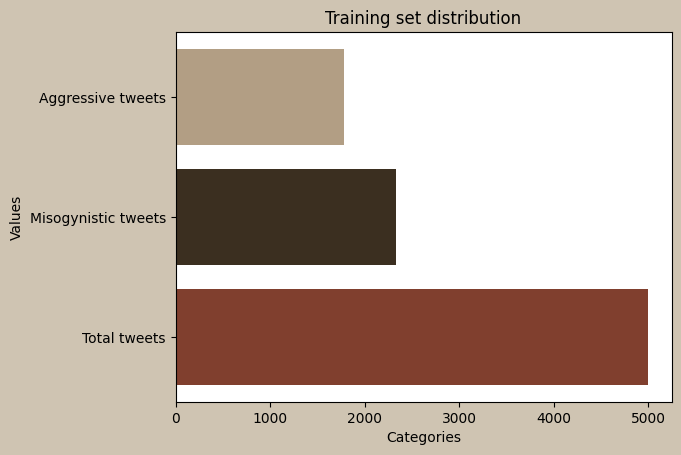

In [5]:
categories = ["Total tweets", "Misogynistic tweets", "Aggressive tweets"]
values = [train_tweets_number, train_m_tweets_number, train_a_tweets_number]

colors = ['#803f2e', '#3b2f20', '#b29e84']

fig = plt.figure(facecolor='#cfc4b2')

plt.barh(categories, values, color=colors)

plt.xlabel('Categories')
plt.ylabel('Values')

plt.title('Training set distribution')

plt.show()

## Test set

In [6]:
test_set = read_set("Datasets/raw_test_data.tsv")
tweets_number = len(test_set)
m_tweets_number = len([sample['text'] for sample in test_set if sample['misogynous'] == 1])
a_tweets_number = len([sample['text'] for sample in test_set if sample['aggressiveness'] == 1])
print("Number of tweets in the set:", tweets_number)
print("Number of misogynistic tweets in the set:", m_tweets_number)
print("Number of misogynistic and aggressive tweets in the set:", a_tweets_number)


Number of tweets in the set: 1000
Number of misogynistic tweets in the set: 500
Number of misogynistic and aggressive tweets in the set: 176


## Plotting the distribution to better visualize the test set

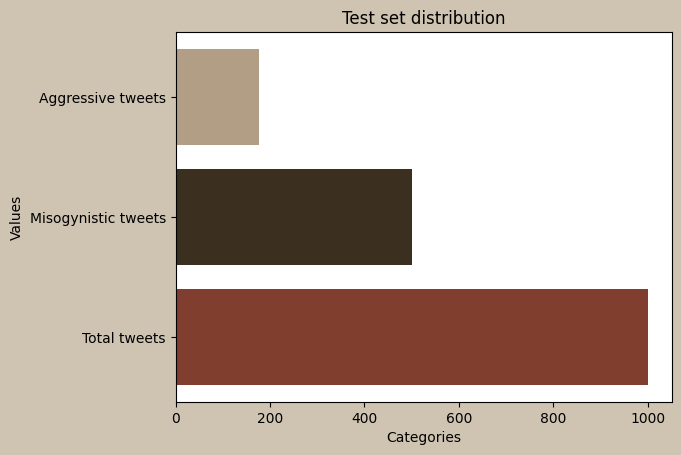

In [7]:
categories = ["Total tweets", "Misogynistic tweets", "Aggressive tweets"]
values = [tweets_number, m_tweets_number, a_tweets_number]
colors = ['#803f2e', '#3b2f20', '#b29e84']

fig = plt.figure(facecolor='#cfc4b2')

plt.barh(categories, values, color=colors)

plt.xlabel('Categories')
plt.ylabel('Values')

plt.title('Test set distribution')

plt.show()

## Examples of tweets in the training set

In [8]:
sample_data = train_set[:5]

table_data = []
for sample in sample_data:
    wrapped_text = textwrap.shorten(sample['text'], width=80, placeholder="...")
    table_data.append([wrapped_text, sample['misogynous'], sample['aggressiveness']])

headers = ["Text", "Misogynous", "Aggressiveness"]
print("First 5 tweets of the training set:")
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

First 5 tweets of the training set:
╒═════════════════════════════════════════════════════════════════════════════════╤══════════════╤══════════════════╕
│ Text                                                                            │   Misogynous │   Aggressiveness │
╞═════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════════╡
│ <MENTION_1> <MENTION_2> Fatti trovare te lo do volentieri e ti sborro in bocca  │            1 │                1 │
├─────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────────┤
│ <MENTION_1> Tu dovresti ricominciare dai semafori a fare la lavavetri..ma...    │            1 │                1 │
├─────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────────┤
│ Amore,sei presentabile? Xchè così via Skype ti faccio conoscere i miei...       │            1 │                1 │
├───────────────────

## Data Pre-Processing

As a first operation we are going to clean the dataset from all the <MENTION_X> and \<URL> strings to improve the training and test sets


In [9]:

input_train_file = "Datasets/raw_training_data.tsv"
input_test_file = "Datasets/raw_test_data.tsv"

output_folder = "OutputDatasets"
output_train_file = "raw_training_data.tsv"
output_test_file = "raw_test_data.tsv"

pattern = r"<(MENTION_\d+|URL)>\s*"

def remove_mention(input_file, output_file, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_file = os.path.join(output_folder, output_file)
    with open(input_file, "r", newline="", encoding="utf-8") as file_in, open(output_file, "w", newline="", encoding="utf-8") as file_out:
        reader = csv.reader(file_in, delimiter="\t")
        writer = csv.writer(file_out, delimiter="\t")

        for row in reader:
            modified_row = [re.sub(pattern, "", cell) for cell in row]
            writer.writerow(modified_row)

remove_mention(input_train_file, output_train_file, output_folder)
remove_mention(input_test_file, output_test_file, output_folder)

We have notice the presence of emojis in the dataset.
The emojis must be removed because they are useless and disturbing elements during the execution of the task.

In [10]:
input_train_file = "OutputDatasets/raw_training_data.tsv"
input_test_file = "OutputDatasets/raw_test_data.tsv"

output_folder = "OutputDatasetsNoEmoji"
output_train_file = "raw_training_data.tsv"
output_test_file = "raw_test_data.tsv"

def get_emoji_regexp():
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def remove_emoji(string):
    cleaned = re.sub(get_emoji_regexp(), "", string)
    return cleaned.strip()

def remove_emoji_from_tsv(input_file, output_file, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_file = os.path.join(output_folder, output_file)
    with open(input_file, "r", newline="", encoding="utf-8") as file_in, open(output_file, "w", newline="", encoding="utf-8") as file_out:
        reader = csv.reader(file_in, delimiter="\t")
        writer = csv.writer(file_out, delimiter="\t")
        for row in reader:
            modified_row = [remove_emoji(cell) for cell in row]
            writer.writerow(modified_row)

remove_emoji_from_tsv(input_train_file, output_train_file, output_folder)
remove_emoji_from_tsv(input_test_file, output_test_file, output_folder)


Both the training set and the test set have been cleaned. This are samples of before and after for the training set:

In [11]:
input_train_file = "OutputDatasetsNoEmoji/raw_training_data.tsv"
input_test_file = "OutputDatasetsNoEmoji/raw_test_data.tsv"

train_set_cleaned = read_set(input_train_file)
test_set_cleaned = read_set(input_test_file)

print("Pre-cleaning:")
for x in range(5):
    print("Tweet ",str(x),": ",train_set[x]['text'])

print("Post-cleaning:")
for x in range(5):
    print("Tweet ",str(x),": ",train_set_cleaned[x]['text'])

Pre-cleaning:
Tweet  0 :  <MENTION_1> <MENTION_2> Fatti trovare  te lo do volentieri e ti sborro in bocca
Tweet  1 :  <MENTION_1> Tu dovresti ricominciare dai semafori a fare la lavavetri..ma tranquilla tanto il vitalizio ti resterà in gola
Tweet  2 :  Amore,sei presentabile? Xchè così via Skype ti faccio conoscere i miei parenti..." e fu così che da un tablet ho conosciuto i parenti terroni della mia tettona,prendendomi un "avete già finito di pranzare? beh si,voi al nord siete diversi..." Dal nord è tutto,a voi..."
Tweet  3 :  <MENTION_1> Salvo poi mandare la culona a Mosca, aummaumm, per farsi dare da Putin commesse multimiliardarie e metterlo in quel posto ai FRATELLI della UE (tra i quali NOI)
Tweet  4 :  <MENTION_1> <MENTION_2> Vediamo Gentiloni, è ora di finirla di essere servili! Pensiamo al danno che la Francia ci ha fatto con Sarkosy e la culona della Merkel con il bombardamento della Libia
Post-cleaning:
Tweet  0 :  Fatti trovare  te lo do volentieri e ti sborro in bocca
Twe

## Dividing the training set and the test set

In this part we prepare the different sets for the subtasks.
- train_set_miso: contains all the data for the train for the task of finding misogynous tweets
- test_set_miso: contains all the data for the test for the task of finding misogynous tweets
- train_set_aggr: contains all the data for the train for the task of finding aggressive tweets among misogynistic ones, which means that is based on all the phrases that are misogynistic, with the label indicating if is aggressive or not
- test_set_aggr: contains all the data for the test for the task of finding aggressive tweets among misogynistic ones

In [12]:
def miso_set(input_set):
    data = []
    for sample in input_set:
        new_data = {}
        new_data['text'] = sample['text']
        new_data['label'] = sample['misogynous']
        data.append(new_data)
    return data

def aggr_set(input_set):
    data = []
    for sample in input_set:
        if sample['misogynous'] == 1:
            new_data = {}
            new_data['text'] = sample['text']
            new_data['label'] = sample['aggressiveness']
            data.append(new_data)
    return data


train_set_miso = miso_set(train_set_cleaned)
test_set_miso = miso_set(test_set_cleaned)


train_set_aggr = aggr_set(train_set_cleaned)
test_set_aggr = aggr_set(test_set_cleaned)


## Confusion Matrix

We are gonna use a confusion matrix to better visualize and describe the results from each model

In [13]:
# misogenia confusion matrix
def print_confusion_matrix(predictions, test_set, title):
    predictions_cm = pd.DataFrame(predictions, columns=["predicted_label"])
    cm = confusion_matrix(test_set["label"], predictions_cm["predicted_label"])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
    plt.title(title)
    plt.xlabel("Previsions")
    plt.ylabel("Real values")
    fig = plt.figure(facecolor='#cfc4b2')
    plt.show()

## Random Forest

The Random Forest model is a machine learning algorithm based on the concept of an ensemble of decision trees.

Here's how the Random Forest model works:

1. Creation of decision trees: To build a random forest, multiple decision trees are created randomly. Each tree is constructed using a random subset of the training data. Additionally, during the creation of each tree, a technique called "bootstrapping" is used, which involves randomly sampling the training set with replacement.
2. Feature selection: During the construction of each decision tree, only a random subset of features (predictive variables) is considered. This helps introduce diversity among the trees and makes the model more robust.
3. Training of decision trees: Each tree is trained using the subset of training data and selected features. During training, the trees attempt to separate the data based on the features, aiming to maximize purity within the leaf nodes.
4. Prediction: Once the random forest is created, the prediction phase takes place. For a new instance of data, each tree in the forest makes a prediction. The final prediction of the Random Forest model is obtained by counting the predictions from individual trees and applying a majority rule (for classification problems) or averaging the predictions (for regression problems).

The key features and advantages of the Random Forest model include:

1. Automatic handling of relevant variables: The Random Forest model can handle a large number of predictive variables without the need for manual feature selection.
2. Resistance to noise and outliers: Due to the combination of different trees, the model is less susceptible to noise and outliers in the data.
3. Evaluation of variable importance: The Random Forest model can provide an estimate of the importance of predictive variables in the decision-making process.
4. Reduction of overfitting risk: The use of multiple decision trees trained on random subsets of data reduces the risk of overfitting compared to a single decision tree.

We have decided to start with the Random Forest model to verify if the results of a complex one like this can be improved by doing some nlp operations on the set

In [14]:

# This is the custom function to apply different nlp operations on the text
def custom_no_stem_tokenizer(text):
    tokens = text.lower().split()
    tokens = [token.strip(string.punctuation) for token in tokens]
    stopwords_list = set(stopwords.words('italian'))
    tokens = [token for token in tokens if token not in stopwords_list]
    tokens = [token for token in tokens if token]
    return tokens

def custom_tokenizer(text):
    tokens = text.lower().split()
    tokens = [token.strip(string.punctuation) for token in tokens]
    stopwords_list = set(stopwords.words('italian'))
    tokens = [token for token in tokens if token not in stopwords_list]
    stemmer = SnowballStemmer('italian')
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

def test_random_forest(vectorizer,train_set,test_set):
    train_features = vectorizer.fit_transform(train_set["text"])
    test_features = vectorizer.transform(test_set["text"])

    rf_model = RandomForestClassifier()
    rf_model.fit(train_features, train_set["label"])

    predictions = rf_model.predict(test_features)

    f1 = f1_score(test_set["label"], predictions)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(test_set["label"], predictions)
    print("Report di classificazione:\n", classification_rep)

    return f1,predictions



# Misogyny Detection

In [21]:
train_set_miso_rf = pd.DataFrame(train_set_miso)
test_set_miso_rf = pd.DataFrame(test_set_miso)

vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1,predictions = test_random_forest(vectorizer,train_set_miso_rf,test_set_miso_rf)


F1 score: 0.7048
Report di classificazione:
               precision    recall  f1-score   support

           0       0.76      0.39      0.52       500
           1       0.59      0.87      0.70       500

    accuracy                           0.63      1000
   macro avg       0.67      0.63      0.61      1000
weighted avg       0.67      0.63      0.61      1000



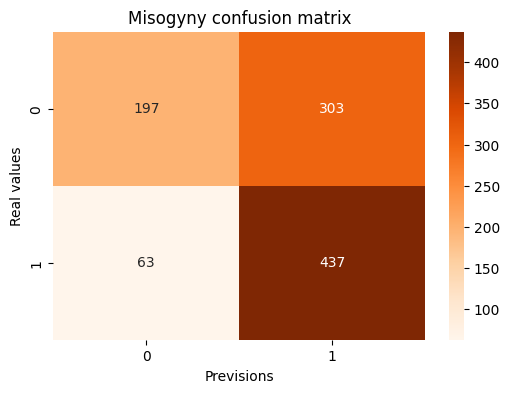

<Figure size 640x480 with 0 Axes>

In [31]:
print_confusion_matrix(predictions, test_set_miso_rf, "Misogyny confusion matrix")

- True Negative (TN): The number of correctly predicted negative instances (non-misogynous) is 185.
- False Positive (FP): The number of incorrectly predicted positive instances (misogynous) is 315.
- False Negative (FN): The number of incorrectly predicted negative instances (non-misogynous) is 55.
- True Positive (TP): The number of correctly predicted positive instances (misogynous) is 445.

Looking at the results we can see that the random forest has some difficults with the class 0, having a really low recall, so we decided to do some modifications to the texts in input, starting with the stemming operation.

In [38]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_rf_miso,predictions = test_random_forest(vectorizer,train_set_miso_rf,test_set_miso_rf)

F1 score: 0.7198
Report di classificazione:
               precision    recall  f1-score   support

           0       0.76      0.51      0.61       500
           1       0.63      0.84      0.72       500

    accuracy                           0.67      1000
   macro avg       0.69      0.67      0.66      1000
weighted avg       0.69      0.67      0.66      1000



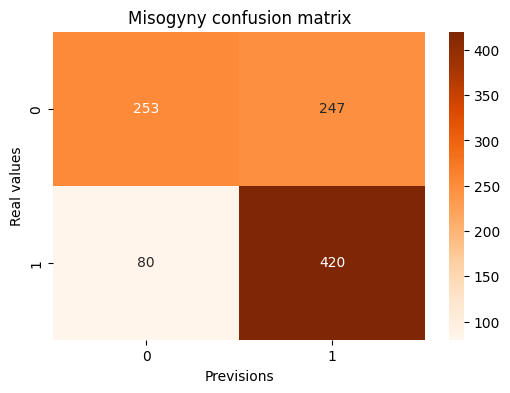

<Figure size 640x480 with 0 Axes>

In [40]:
print_confusion_matrix(predictions, test_set_miso_rf, "Misogyny confusion matrix")

- True Negative (TN): The number of correctly predicted negative instances (non-misogynous) is 244.
- False Positive (FP): The number of incorrectly predicted positive instances (misogynous) is 256.
- False Negative (FN): The number of incorrectly predicted negative instances (non-misogynous) is 75.
- True Positive (TP): The number of correctly predicted positive instances (misogynous) is 425.

- We can see the result for the class 0 has improved as result of the stemming operation, but the overall results are still not very good for the class 0

# Aggressive detection

In [41]:
train_set_aggr_rf = pd.DataFrame(train_set_aggr)
test_set_aggr_rf = pd.DataFrame(test_set_aggr)

vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1,predictions = test_random_forest(vectorizer,train_set_aggr_rf,test_set_aggr_rf)

F1 score: 0.5687
Report di classificazione:
               precision    recall  f1-score   support

           0       0.82      0.40      0.54       324
           1       0.43      0.84      0.57       176

    accuracy                           0.55       500
   macro avg       0.62      0.62      0.55       500
weighted avg       0.68      0.55      0.55       500



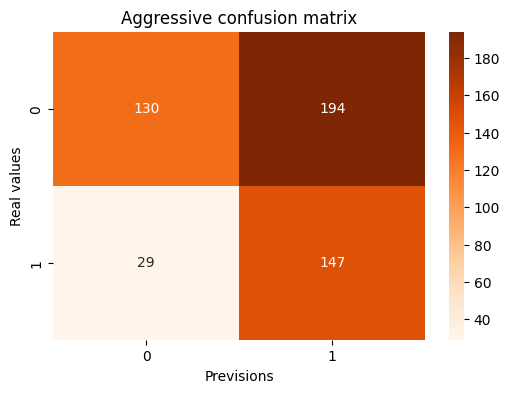

<Figure size 640x480 with 0 Axes>

In [43]:
print_confusion_matrix(predictions, test_set_aggr_rf, "Aggressive confusion matrix")

In [20]:
train_set_aggr_rf = pd.DataFrame(train_set_aggr)
test_set_aggr_rf = pd.DataFrame(test_set_aggr)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1,predictions = test_random_forest(vectorizer,train_set_aggr_rf,test_set_aggr_rf)

F1 score: 0.5841
Report di classificazione:
               precision    recall  f1-score   support

           0       0.87      0.36      0.51       324
           1       0.43      0.90      0.58       176

    accuracy                           0.55       500
   macro avg       0.65      0.63      0.55       500
weighted avg       0.71      0.55      0.54       500



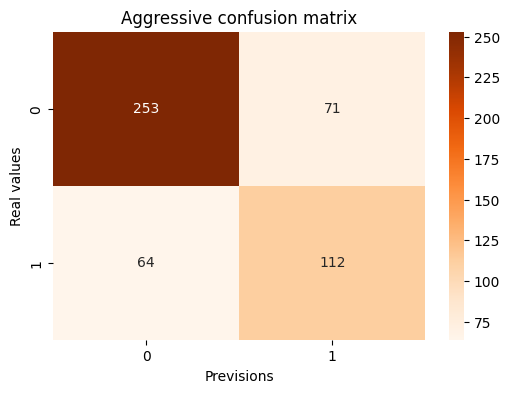

In [22]:
print_confusion_matrix(predictions, test_set_aggr_rf, "Aggressive confusion matrix")

- Looking at this results (expecially the recall) we can clearly see that the performance are even worse than the misogyny detection probably because the set is not balaced (there are a lot of tweets that are not aggressive in the training set).
- As starting test we try to artificially reduce the number of tweets in the training set that are aggressive, in this way the classes are more balanced.

In [46]:
new_train = []
cont = 1400
for sample in train_set_aggr:
    new_data = {}
    if sample['label'] == 1:
        if cont == 0:
            new_data['text'] = sample['text']
            new_data['label'] = sample['label']
            new_train.append(new_data)
        else:
            cont-=1
    else:
        new_data['text'] = sample['text']
        new_data['label'] = sample['label']
        new_train.append(new_data)     

new_train = pd.DataFrame(new_train)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_rf_aggr,predictions_one = test_random_forest(vectorizer,new_train,test_set_aggr_rf)

F1 score: 0.6374
Report di classificazione:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       324
           1       0.62      0.66      0.64       176

    accuracy                           0.74       500
   macro avg       0.71      0.72      0.71       500
weighted avg       0.74      0.74      0.74       500



- As we can see the result of the class 0 and class 1 are more balanced. Looking at this result we can discuss the misogyny detection ones. 
- Here the random forest has much less trouble distinguishing the aggressive misogyny tweet to a non-aggressive one. The reason for the low recall during the misogyny detection could a lack of effective representation of non-misogynistic phrases in the training dataset and as a result the model does not perform well when recognizing class 0

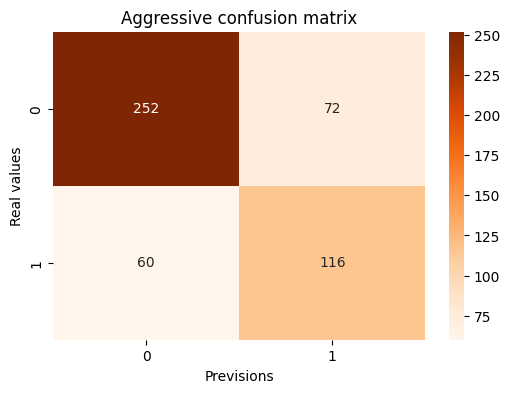

<Figure size 640x480 with 0 Axes>

In [47]:
print_confusion_matrix(predictions_one, test_set_aggr_rf, "Aggressive confusion matrix")

**Random Forest $score_A$**

In [48]:
print("Score A for the random forest:")
score = (f1_rf_miso + f1_rf_aggr)/2
print(f"{score:.4f}")

Score A for the random forest:
0.6786


## Naive Bayes

The Naive Bayes model is a supervised classification algorithm based on Bayes' theorem with the assumption of conditional independence between features (predictive variables). It is often used for text classification and sentiment analysis but can be applied to a wide range of classification problems.

Here's how the Naive Bayes model works:

1. Bayes' Theorem: The model is based on Bayes' theorem, which states that the conditional probability of an event (the class) given another event (the features) can be calculated using the conditional and marginal probabilities associated with the events.
2. Assumption of Conditional Independence: The "naive" assumption of the Naive Bayes model is that the features are independent of each other, given the value of the class. This means that the model treats each feature as an independent contributor to the probability of the class.
3. Model Training: During the training phase, the Naive Bayes model calculates the prior probabilities of each class and the conditional probabilities of the features given the value of the class. These probabilities are estimated using the training set.
4. Class Probability Calculation: To classify a new instance of data, the Naive Bayes model calculates the probability of each class given the value of the features using Bayes' theorem. The predicted class is the one with the highest probability.

We have decided to use a simple model such as the Naive Bayes to see how the nlp operations on the set can change the results of the model.

In [62]:
def test_naive_bayes(vectorizer, train_set, test_set):
    train_features = vectorizer.fit_transform(train_set["text"])
    test_features = vectorizer.transform(test_set["text"])

    nb_model = MultinomialNB()
    nb_model.fit(train_features, train_set["label"])

    predictions = nb_model.predict(test_features)

    f1 = f1_score(test_set["label"], predictions)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(test_set["label"], predictions)
    print("Report di classificazione:\n", classification_rep)

    return f1, predictions

In [64]:
train_set_miso_nb = pd.DataFrame(train_set_miso)
test_set_miso_nb = pd.DataFrame(test_set_miso)

train_set_aggr_nb = pd.DataFrame(train_set_aggr)
test_set_aggr_nb = pd.DataFrame(test_set_aggr)

## Misogyny detection

In this section we are using the Naive Bayes model to test the Misogyny detection

In [69]:
vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1_nb_miso,predictions = test_naive_bayes(vectorizer, train_set_miso_nb, test_set_miso_nb)

F1 score: 0.7595
Report di classificazione:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       500
           1       0.78      0.74      0.76       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.76      1000



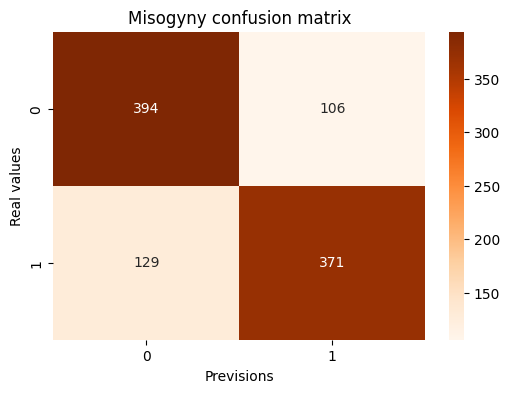

In [70]:
print_confusion_matrix(predictions, test_set_miso_nb, "Misogyny confusion matrix")

This results are pretty good! But we can still improve them using the stemming operation

In [87]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_miso,predictions = test_naive_bayes(vectorizer, train_set_miso_nb, test_set_miso_nb)

F1 score: 0.7646
Report di classificazione:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       500
           1       0.82      0.72      0.76       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



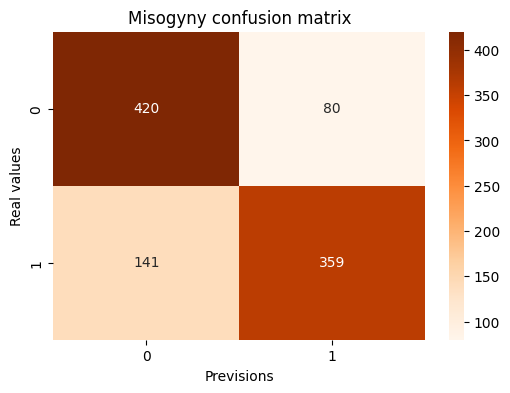

In [72]:
print_confusion_matrix(predictions, test_set_miso_nb, "Misogyny confusion matrix")

As we can see from the confusion matrix the results have improved using stemming

## Aggressive detection

In this section we are using the Naive Bayes model to test the Aggressive detection

In [88]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_aggr,predictions = test_naive_bayes(vectorizer, train_set_aggr_nb, test_set_aggr_nb)

F1 score: 0.5207
Report di classificazione:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       324
           1       0.35      1.00      0.52       176

    accuracy                           0.35       500
   macro avg       0.18      0.50      0.26       500
weighted avg       0.12      0.35      0.18       500



c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

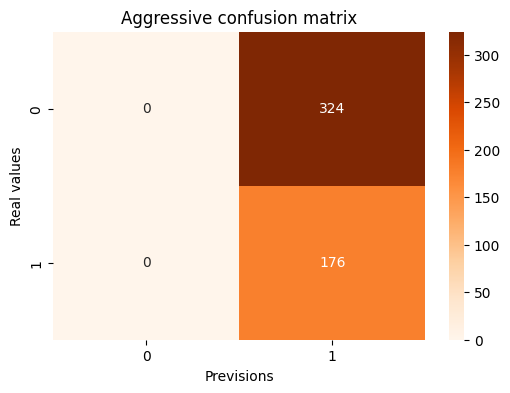

In [89]:
print_confusion_matrix(predictions, test_set_aggr_nb, "Aggressive confusion matrix")

- Looking at this result we can clearly see that a Naive Bayes model suffers a lot from a non-balanced training set, so we did the same operation from the Random Forest one and the results are very good!

In [90]:
new_train = []
cont = 1400
for sample in train_set_aggr:
    new_data = {}
    if sample['label'] == 1:
        if cont == 0:
            new_data['text'] = sample['text']
            new_data['label'] = sample['label']
            new_train.append(new_data)
        else:
            cont -= 1
    else:
        new_data['text'] = sample['text']
        new_data['label'] = sample['label']
        new_train.append(new_data)

new_train = pd.DataFrame(new_train)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_aggr,predictions = test_naive_bayes(vectorizer, new_train, test_set_aggr_nb)

F1 score: 0.6540
Report di classificazione:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       324
           1       0.63      0.68      0.65       176

    accuracy                           0.75       500
   macro avg       0.72      0.73      0.73       500
weighted avg       0.75      0.75      0.75       500



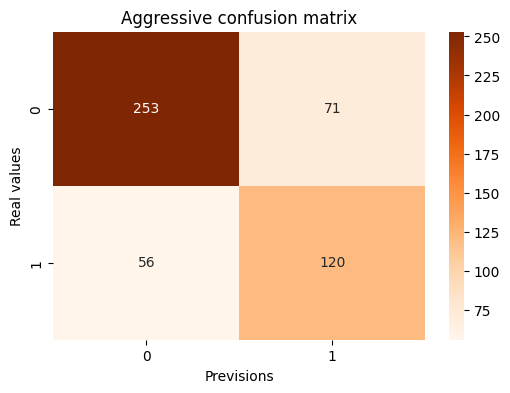

In [91]:
print_confusion_matrix(predictions, test_set_aggr_nb, "Aggressive confusion matrix")

From having the worst results we managed to get pretty good results using a simple model like the Naive Bayes rebalancing the training set

We tried to pump the training set using wordnet to create new phrases using synonyms:

In [16]:
new_datas = []
for sample in train_set_aggr:
    if sample['label'] == 0:
        n_sample = sample['text']
        new_datas.append(n_sample)

def get_synonyms(word):
    synonyms = []
    for synset in wordnet.synsets(word, lang='ita'):
        for lemma in synset.lemmas(lang='ita'):
            synonyms.append(lemma.name())
    return synonyms

def expand_sentences(sentences):
    expanded_sentences = []
    for sentence in sentences:
        words = sentence.split()
        expanded_sentence = []
        for word in words:
            synonyms = get_synonyms(word)
            if synonyms:
                for synonym in synonyms:
                    new_sentence = sentence.replace(word, synonym)
                    expanded_sentence.append(new_sentence)
        expanded_sentences.extend(expanded_sentence)
    return expanded_sentences

expandend_sentences = expand_sentences(new_datas)

In [17]:
new_train_set_aggr = copy.deepcopy(train_set_aggr)
cont = 6500

for sample in expandend_sentences:
    if cont > 0:
        new_sample = {}
        new_sample['text'] = sample
        new_sample['label'] = 0
        new_train_set_aggr.append(new_sample)
        cont-=1
    else:
        break

new_train_pumped = pd.DataFrame(new_train_set_aggr)

In [65]:

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_new,predictions = test_naive_bayes(vectorizer, new_train_pumped, test_set_aggr_nb)

F1 score: 0.5553
Report di classificazione:
               precision    recall  f1-score   support

           0       0.77      0.60      0.67       324
           1       0.47      0.67      0.56       176

    accuracy                           0.62       500
   macro avg       0.62      0.63      0.61       500
weighted avg       0.67      0.62      0.63       500



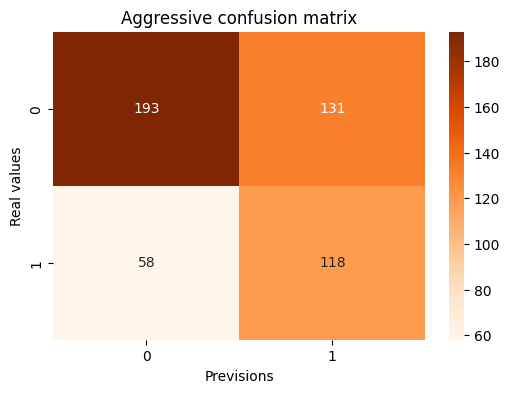

<Figure size 640x480 with 0 Axes>

In [66]:
print_confusion_matrix(predictions, test_set_aggr_nb, "Aggressive confusion matrix")

Looking at the results, the model has improved a lot, expecially considering that this method is not perfect because there are many sentences generated with synonyms of words that have lost their original meaning. 

This could be the reason why we needed to add 6500 new phrases generated in this way to make a significant change in the results

**Naive Bayes $score_A$**

Score A for Naive Bayes: 0.705

## Neural Network LSTM

LSTM is a type of recurrent neural network (RNN) architecture that is designed to handle sequential data, such as time series or natural language data, by capturing long-term dependencies.

The basic building block of an LSTM network is the LSTM cell. The cell consists of a memory cell and three gating mechanisms: the input gate, the forget gate, and the output gate. These gates control the flow of information within the cell, allowing the network to selectively remember or forget information.

The input gate determines how much of the new input should be stored in the memory cell. It takes the current input and the previous hidden state as inputs and passes them through a sigmoid activation function. The output of the sigmoid activation determines the amount of information to be stored.

The forget gate controls what information should be discarded from the memory cell. It takes the current input and the previous hidden state as inputs and passes them through a softmax activation function. The output of the softmax determines which information is irrelevant and should be forgotten.

The memory cell holds the information over time. It multiplies the output of the input gate with the new input and adds the output of the forget gate multiplied by the previous memory cell value. This operation determines the new content to be stored in the memory cell.

The output gate decides how much of the memory cell should be exposed as the output of the current LSTM cell. It takes the current input and the previous hidden state as inputs and passes them through a softmax activation function. The output of the softmax is multiplied by the memory cell passed through a hyperbolic tangent (tanh) activation function. This produces the hidden state of the LSTM cell.

In [35]:
train_set_miso_lstm = pd.DataFrame(train_set_miso)
test_set_miso_lstm = pd.DataFrame(test_set_miso)

train_set_aggr_lstm = pd.DataFrame(train_set_aggr)
test_set_aggr_lstm = pd.DataFrame(test_set_aggr)



def get_counter(set):
    vocab_counter = Counter()
    for text in set["text"]:

        tokens = text.split()
        vocab_counter.update(tokens)

    unique_words = len(vocab_counter)
    return unique_words

unique_words_miso = get_counter(train_set_miso_lstm)
unique_words_aggr = get_counter(train_set_aggr_lstm)



print("Number of unique tokens in the training set miso:", unique_words_miso)
print("Number of unique tokens in the training set aggr:", unique_words_aggr)

Number of unique tokens in the training set miso: 19604
Number of unique tokens in the training set aggr: 8735


In [36]:
import numpy as np
# Max words to have in a sentence, assumed to be equal to 40 since the avarage of words in all the sentences is around 30
maxWords = 40

def pre_processing(unique_words, train_set, test_set):
    tokenizer = Tokenizer(num_words = unique_words, char_level = False)
    tokenizer.fit_on_texts(train_set_miso_lstm["text"])

    X_train = tokenizer.texts_to_sequences(train_set["text"])

    X_test = tokenizer.texts_to_sequences(test_set["text"])

    X_train = pad_sequences(X_train, maxlen = maxWords, padding='post')
    X_test = pad_sequences(X_test, maxlen = maxWords, padding='post')
    Y_train = to_categorical(np.asarray(train_set["label"]))

    return X_train, X_test, Y_train

X_train_miso, X_test_miso, Y_train_miso = pre_processing(unique_words_miso, train_set_miso_lstm, test_set_miso_lstm)
X_train_aggr, X_test_aggr, Y_train_aggr = pre_processing(unique_words_aggr, train_set_aggr_lstm, test_set_aggr_lstm)



In [82]:
def test_lstm(max_words,unique_words, embed_dim, lstm_out,x_train, x_test, y_train, y_test):

    sequence_input = Input(shape=(max_words), dtype='int32')
    embedded_sequences = Embedding(unique_words, embed_dim, input_length=max_words)(sequence_input)
    x = LSTM(lstm_out,dropout=0.2)(embedded_sequences)
    x = Dense(30)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(sequence_input, predictions)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=5, validation_split = 0.1, batch_size=128)

    predictions = model.predict(x_test)
    test_cases = np.argmax(predictions, axis=-1)


    f1 = f1_score(test_cases, y_test)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(y_test, test_cases)
    print("Report di classificazione:\n", classification_rep)

    return f1, test_cases


## Misogyny detection

In [90]:
embed_dim = 128
lstm_out = 128
f1_lstm_miso,predictions = test_lstm(maxWords,unique_words_miso, embed_dim, lstm_out,X_train_miso, X_test_miso, Y_train_miso, test_set_miso_lstm['label'])

Epoch 1/5
36/36 [==============================] - 6s 119ms/step - loss: 0.6033 - accuracy: 0.6543 - val_loss: 0.4521 - val_accuracy: 0.8220
Epoch 2/5
36/36 [==============================] - 4s 110ms/step - loss: 0.2652 - accuracy: 0.8986 - val_loss: 0.4519 - val_accuracy: 0.8260
Epoch 3/5
36/36 [==============================] - 4s 105ms/step - loss: 0.1280 - accuracy: 0.9600 - val_loss: 0.4970 - val_accuracy: 0.8420
Epoch 4/5
36/36 [==============================] - 4s 103ms/step - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.5580 - val_accuracy: 0.8360
Epoch 5/5
32/32 [==============================] - 1s 10ms/step
F1 score: 0.7582
Report di classificazione:
               precision    recall  f1-score   support

           0       0.79      0.63      0.70       500
           1       0.69      0.83      0.76       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



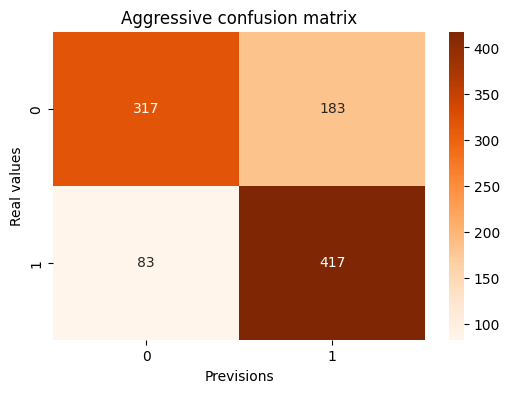

<Figure size 640x480 with 0 Axes>

In [91]:
print_confusion_matrix(predictions, test_set_miso_lstm, "Aggressive confusion matrix")

Looking at the results the model perfomed pretty well with a very high F1 Score

## Aggressive detection

In [94]:
f1_lstm_aggr,predictions = test_lstm(maxWords,unique_words_aggr, embed_dim, lstm_out,X_train_aggr, X_test_aggr, Y_train_aggr, test_set_aggr_lstm['label'])

Epoch 1/5
17/17 [==============================] - 4s 120ms/step - loss: 0.5868 - accuracy: 0.7684 - val_loss: 0.5942 - val_accuracy: 0.7222
Epoch 2/5
17/17 [==============================] - 2s 100ms/step - loss: 0.5438 - accuracy: 0.7675 - val_loss: 0.6009 - val_accuracy: 0.7222
Epoch 3/5
17/17 [==============================] - 2s 103ms/step - loss: 0.5395 - accuracy: 0.7675 - val_loss: 0.5960 - val_accuracy: 0.7222
Epoch 4/5
17/17 [==============================] - 2s 106ms/step - loss: 0.5362 - accuracy: 0.7675 - val_loss: 0.6083 - val_accuracy: 0.7222
Epoch 5/5
16/16 [==============================] - 0s 11ms/step
F1 score: 0.5207
Report di classificazione:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       324
           1       0.35      1.00      0.52       176

    accuracy                           0.35       500
   macro avg       0.18      0.50      0.26       500
weighted avg       0.12      0.35      0.18       500



c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

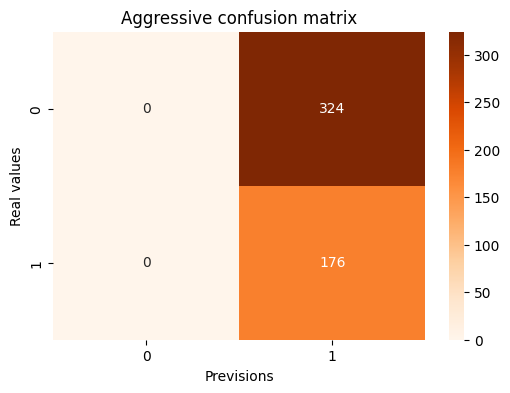

<Figure size 640x480 with 0 Axes>

In [95]:
print_confusion_matrix(predictions, test_set_aggr_lstm, "Aggressive confusion matrix")

Here we can see how a neural network suffers from a small training set plus an unbalanced one too, we tried some techniques to try and overcome this problem

### Reducing the set size

Here we are reducing the number of positive samples to try to balance the training set

In [96]:
new_train_aggr_lstm = []
cont = 1400
for sample in train_set_aggr:
    new_data = {}
    if sample['label'] == 1:
        if cont == 0:
            new_data['text'] = sample['text']
            new_data['label'] = sample['label']
            new_train_aggr_lstm.append(new_data)
        else:
            cont -= 1
    else:
        new_data['text'] = sample['text']
        new_data['label'] = sample['label']
        new_train_aggr_lstm.append(new_data)

new_train_aggr_lstm = pd.DataFrame(new_train_aggr_lstm)
X_train_aggr, X_test_aggr, Y_train_aggr = pre_processing(unique_words_aggr, new_train_aggr_lstm, test_set_aggr_lstm)

In [97]:
f1_lstm_aggr,predictions = test_lstm(maxWords,unique_words_aggr, embed_dim, lstm_out,X_train_aggr, X_test_aggr, Y_train_aggr, test_set_aggr_lstm['label'])

Epoch 1/5
7/7 [==============================] - 3s 187ms/step - loss: 0.6790 - accuracy: 0.6109 - val_loss: 0.8801 - val_accuracy: 0.2340
Epoch 2/5
7/7 [==============================] - 1s 124ms/step - loss: 0.6643 - accuracy: 0.6311 - val_loss: 0.8369 - val_accuracy: 0.2340
Epoch 3/5
7/7 [==============================] - 1s 120ms/step - loss: 0.6624 - accuracy: 0.6311 - val_loss: 0.8798 - val_accuracy: 0.2340
Epoch 4/5
7/7 [==============================] - 1s 124ms/step - loss: 0.6618 - accuracy: 0.6311 - val_loss: 0.8369 - val_accuracy: 0.2340
Epoch 5/5
16/16 [==============================] - 1s 12ms/step
F1 score: 0.0000
Report di classificazione:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       324
           1       0.00      0.00      0.00       176

    accuracy                           0.65       500
   macro avg       0.32      0.50      0.39       500
weighted avg       0.42      0.65      0.51       500



c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

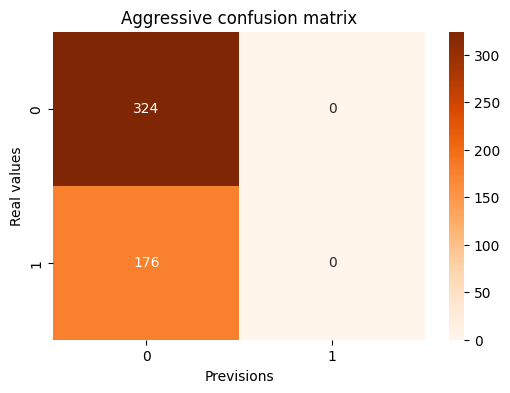

<Figure size 640x480 with 0 Axes>

In [98]:
print_confusion_matrix(predictions, test_set_aggr_lstm, "Aggressive confusion matrix")

Looking at the result the model is still very bad.

### Pumping the training set

Here we try to pump the negative samples of the set using WordNet and synonyms

In [99]:
new_train_set_aggr = copy.deepcopy(train_set_aggr)
cont = 6000

for sample in expandend_sentences:
    if cont > 0:
        new_sample = {}
        new_sample['text'] = sample
        new_sample['label'] = 0
        new_train_set_aggr.append(new_sample)
        cont-=1
    else:
        break

new_train_pumped = pd.DataFrame(new_train_set_aggr)


unique_words_aggr_pumped = get_counter(new_train_pumped)
X_train_aggr, X_test_aggr, Y_train_aggr = pre_processing(unique_words_aggr_pumped, new_train_pumped, test_set_aggr_lstm)
print("Number of unique tokens in the training set miso:", unique_words_aggr_pumped)
print("Number of tweets in the set:", len(X_train_aggr))


Number of unique tokens in the training set miso: 11312
Number of tweets in the set: 8337


In [100]:
f1_lstm_aggr,predictions = test_lstm(maxWords,unique_words_aggr_pumped, embed_dim, lstm_out,X_train_aggr, X_test_aggr, Y_train_aggr, test_set_aggr_lstm['label'])

Epoch 1/5
59/59 [==============================] - 9s 118ms/step - loss: 0.4689 - accuracy: 0.7684 - val_loss: 0.6312 - val_accuracy: 0.3945
Epoch 2/5
59/59 [==============================] - 7s 120ms/step - loss: 0.1839 - accuracy: 0.9222 - val_loss: 0.4662 - val_accuracy: 0.7506
Epoch 3/5
59/59 [==============================] - 7s 115ms/step - loss: 0.1071 - accuracy: 0.9603 - val_loss: 0.1271 - val_accuracy: 0.9640
Epoch 4/5
59/59 [==============================] - 7s 116ms/step - loss: 0.0672 - accuracy: 0.9748 - val_loss: 0.2881 - val_accuracy: 0.9173
Epoch 5/5
16/16 [==============================] - 0s 11ms/step
F1 score: 0.6116
Report di classificazione:
               precision    recall  f1-score   support

           0       0.91      0.40      0.56       324
           1       0.46      0.93      0.61       176

    accuracy                           0.59       500
   macro avg       0.68      0.66      0.58       500
weighted avg       0.75      0.59      0.58       500



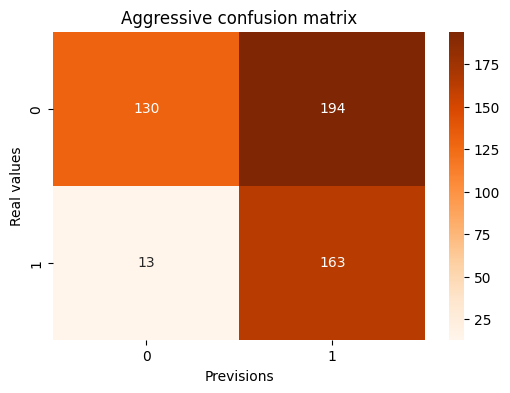

<Figure size 640x480 with 0 Axes>

In [101]:
print_confusion_matrix(predictions, test_set_aggr_lstm, "Aggressive confusion matrix")

Here the model has improved a lot!, it still suffers on the class 0 because the generated tweets using synonyms can lost their meaning even if we have added a lot of new tweets.

**Neural Network LSTM $score_A$**

In [102]:
print("Score A for the Neural Network LSTM:")
score = (f1_lstm_miso + f1_lstm_aggr)/2
print(f"{score:.4f}")

Score A for the Neural Network LSTM:
0.6849


## Logistic Regression
 Logistic regression is a simple algorithm that can be used for binary classification tasks. It works by modeling the probability of an example belonging to a certain class as a function of its features.

In [1]:
from sklearn.linear_model import LogisticRegression

def test_logistic_regression(vectorizer, train_set, test_set):
    train_features = vectorizer.fit_transform(train_set["text"])
    test_features = vectorizer.transform(test_set["text"])

    lr_model = LogisticRegression()
    lr_model.fit(train_features, train_set["label"])

    predictions = lr_model.predict(test_features)

    f1 = f1_score(test_set["label"], predictions)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(test_set["label"], predictions)
    print("Classification report:\n", classification_rep)

    return f1, predictions

# Misogyny Detection

In [15]:
train_set_miso_lr = pd.DataFrame(train_set_miso)
test_set_miso_lr = pd.DataFrame(test_set_miso)

vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1, predictions = test_logistic_regression(vectorizer, train_set_miso_lr, test_set_miso_lr)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7448
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.68       500
           1       0.68      0.83      0.74       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000



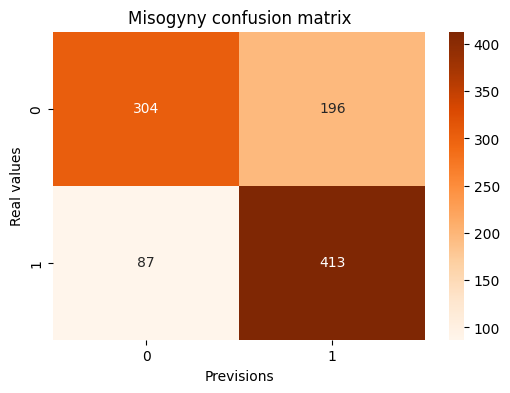

<Figure size 640x480 with 0 Axes>

In [16]:
print_confusion_matrix(predictions, test_set_miso_lr, "Misogyny confusion matrix")

In [17]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_lr_miso, predictions = test_logistic_regression(vectorizer, train_set_miso_lr, test_set_miso_lr)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7542
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.71       500
           1       0.71      0.81      0.75       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.74      0.73      1000



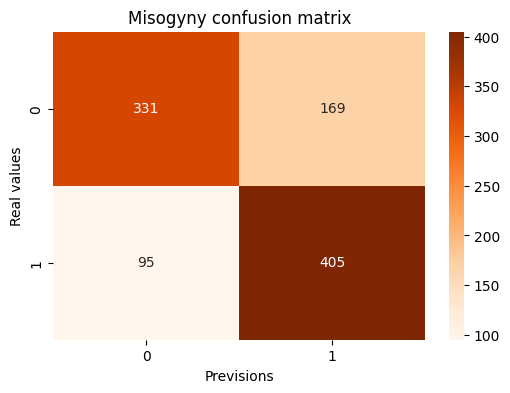

<Figure size 640x480 with 0 Axes>

In [18]:
print_confusion_matrix(predictions, test_set_miso_lr, "Misogyny confusion matrix")

# Aggressive detection

In [20]:
train_set_aggr_lr = pd.DataFrame(train_set_aggr)
test_set_aggr_lr = pd.DataFrame(test_set_aggr)

In [21]:
vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1, predictions = test_logistic_regression(vectorizer, train_set_aggr_lr, test_set_aggr_lr)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.5537
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.17      0.29       324
           1       0.39      0.97      0.55       176

    accuracy                           0.45       500
   macro avg       0.65      0.57      0.42       500
weighted avg       0.72      0.45      0.38       500



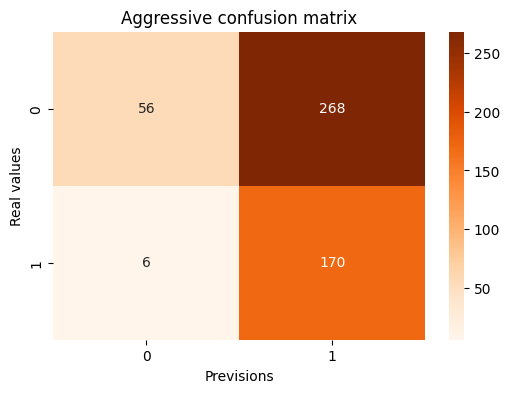

<Figure size 640x480 with 0 Axes>

In [22]:
print_confusion_matrix(predictions, test_set_aggr_lr, "Aggressive confusion matrix")

In [24]:
train_set_aggr_lr = pd.DataFrame(train_set_aggr)
test_set_aggr_lr = pd.DataFrame(test_set_aggr)

In [26]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_lr_aggr,predictions_one = test_logistic_regression(vectorizer,train_set_aggr_lr,test_set_aggr_lr)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.5533
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.14      0.24       324
           1       0.38      0.99      0.55       176

    accuracy                           0.44       500
   macro avg       0.67      0.56      0.40       500
weighted avg       0.76      0.44      0.35       500



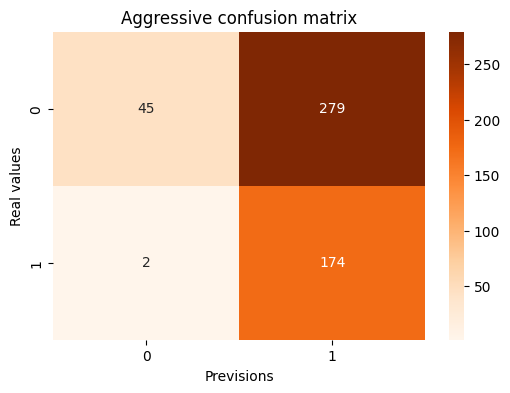

<Figure size 640x480 with 0 Axes>

In [28]:
print_confusion_matrix(predictions_one, test_set_aggr_lr, "Aggressive confusion matrix")

We tried to pump the training set using wordnet to create new phrases using synonyms:

In [45]:
new_datas = []
for sample in train_set_aggr:
    if sample['label'] == 0:
        n_sample = sample['text']
        new_datas.append(n_sample)

def get_synonyms(word):
    synonyms = []
    for synset in wordnet.synsets(word, lang='ita'):
        for lemma in synset.lemmas(lang='ita'):
            synonyms.append(lemma.name())
    return synonyms

def expand_sentences(sentences):
    expanded_sentences = []
    for sentence in sentences:
        words = sentence.split()
        expanded_sentence = []
        for word in words:
            synonyms = get_synonyms(word)
            if synonyms:
                for synonym in synonyms:
                    new_sentence = sentence.replace(word, synonym)
                    expanded_sentence.append(new_sentence)
        expanded_sentences.extend(expanded_sentence)
    return expanded_sentences

expandend_sentences = expand_sentences(new_datas)

In [46]:
new_train_set_aggr = copy.deepcopy(train_set_aggr)
cont = 6500

for sample in expandend_sentences:
    if cont > 0:
        new_sample = {}
        new_sample['text'] = sample
        new_sample['label'] = 0
        new_train_set_aggr.append(new_sample)
        cont-=1
    else:
        break

In [50]:
new_train_pumped = pd.DataFrame(new_train_set_aggr)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_new,predictions = test_logistic_regression(vectorizer, new_train_pumped, test_set_aggr_lr)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.6224
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.52      0.65       324
           1       0.49      0.85      0.62       176

    accuracy                           0.64       500
   macro avg       0.68      0.69      0.64       500
weighted avg       0.73      0.64      0.64       500



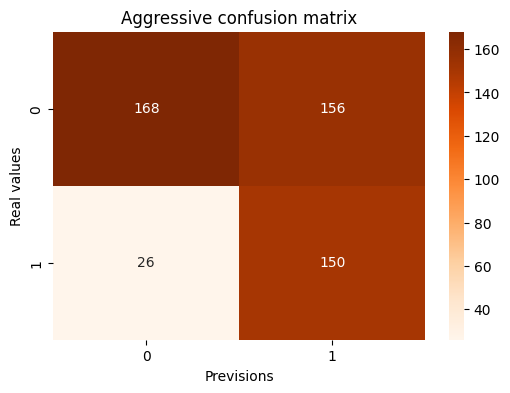

<Figure size 640x480 with 0 Axes>

In [52]:
print_confusion_matrix(predictions, test_set_aggr_lr, "Aggressive confusion matrix")

the performance are improved but the model can't really distinguish well the class 0

# Score a

In [32]:
print("Score A for the logistic regression:")
score = (f1_lr_miso + f1_lr_aggr)/2
print(f"{score:.4f}")

Score A for the logistic regression:
0.6537
